In [52]:
# !pip3 install biopython torch tensorflow numpy matplotlib scikit-learn --break-system-packages -i https://pypi.tuna.tsinghua.edu.cn/simple
# !apt-get install dssp                       

In [53]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [54]:
#加载数据Xy
X = torch.load('X.pt')
y = torch.load('y.pt')
print(f"加载的数据形状: X={X.shape}, y={y.shape}")

加载的数据形状: X=torch.Size([183, 8015]), y=torch.Size([183, 8015])


/tmp/ipykernel_2372/1773464685.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load('X.pt')
/tmp/ipykernel_2372/1773464685.py:3: FutureWarning: You are using `

In [55]:
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

In [56]:
#加载模型
from model import MultiScaleCNN

In [57]:
model = MultiScaleCNN(max_len=X_train.shape[1])
print("\n模型输出形状测试:", model(torch.zeros_like(X_train[:1])).shape)
print("\n模型结构:")
print(model)


模型输出形状测试: torch.Size([1, 8015, 3])

模型结构:
MultiScaleCNN(
  (embed): Embedding(21, 64, padding_idx=0)
  (branch3): Sequential(
    (0): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,), groups=32)
    (1): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.3, inplace=False)
    (5): AdaptiveAvgPool1d(output_size=8015)
  )
  (branch5): Sequential(
    (0): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=(2,), dilation=(2,), groups=32)
    (1): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.3, inplace=False)
    (5): AdaptiveAvgPool1d(output_size=8015)
  )
  (fusion): Sequential(
    (0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Adapt

In [58]:
#开始训练

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

In [60]:

train_loss = []
val_loss = []
train_acc = []
val_acc = []

In [61]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    epoch_train_correct = 0
    epoch_train_total = 0
    
    # 训练批次
    for i in tqdm(range(0, len(X_train), 32), desc=f'Epoch {epoch+1}'):
        inputs = X_train[i:i+32]  # (batch_size, max_len)
        targets = y_train[i:i+32]  # (batch_size, max_len)
        
        # 前向传播
        optimizer.zero_grad()
        outputs = model(inputs)  # 应输出 (batch_size, max_len, num_classes)
        
        # 检查形状一致性
        assert outputs.shape[:2] == targets.shape, \
            f"输出形状{outputs.shape}与标签形状{targets.shape}不匹配"
        
        # 计算损失（手动过滤掉 -1 的目标值）
        outputs_flat = outputs.reshape(-1, outputs.size(-1))  # (batch_size*max_len, num_classes)
        targets_flat = targets.reshape(-1)  # (batch_size*max_len)
        mask = targets_flat != -1  # 创建一个掩码，忽略 -1 的目标值
        loss = criterion(outputs_flat[mask], targets_flat[mask])  # 只计算非 -1 的目标值
        
        # 反向传播
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # 梯度裁剪
        optimizer.step()
        
        # 计算准确率（忽略padding）
        with torch.no_grad():
            preds = torch.argmax(outputs, dim=-1)
            mask = targets != -1
            correct = (preds[mask] == targets[mask]).sum().item()
            total = mask.sum().item()
            
            epoch_train_loss += loss.item() * inputs.size(0)
            epoch_train_correct += correct
            epoch_train_total += total
    
    # 验证阶段
    model.eval()
    epoch_val_loss = 0.0
    epoch_val_correct = 0
    epoch_val_total = 0
    
    with torch.no_grad():
        for i in range(0, len(X_val), 32):
            inputs = X_val[i:i+32]
            targets = y_val[i:i+32]
            
            outputs = model(inputs)
            outputs_flat = outputs.reshape(-1, outputs.size(-1))
            targets_flat = targets.reshape(-1)
            mask = targets_flat != -1
            loss = criterion(outputs_flat[mask], targets_flat[mask])
            
            preds = torch.argmax(outputs, dim=-1)
            mask = targets != -1
            correct = (preds[mask] == targets[mask]).sum().item()
            total = mask.sum().item()
            
            epoch_val_loss += loss.item() * inputs.size(0)
            epoch_val_correct += correct
            epoch_val_total += total
    
    # 记录指标
    train_loss.append(epoch_train_loss / len(X_train))
    train_acc.append(epoch_train_correct / epoch_train_total)
    val_loss.append(epoch_val_loss / len(X_val))
    val_acc.append(epoch_val_correct / epoch_val_total)
    
    print(f'Epoch {epoch+1}/{num_epochs}: '
          f'Train Loss: {train_loss[-1]:.4f} | Train Acc: {train_acc[-1]:.4f} | '
          f'Val Loss: {val_loss[-1]:.4f} | Val Acc: {val_acc[-1]:.4f}')

Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 1/20: Train Loss: 1.1806 | Train Acc: 0.3903 | Val Loss: 1.0787 | Val Acc: 0.4164


Epoch 2: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 2/20: Train Loss: 1.0988 | Train Acc: 0.4187 | Val Loss: 1.0647 | Val Acc: 0.4723


Epoch 3: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch 3/20: Train Loss: 1.0476 | Train Acc: 0.4615 | Val Loss: 1.0542 | Val Acc: 0.4937


Epoch 4: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch 4/20: Train Loss: 1.0233 | Train Acc: 0.4836 | Val Loss: 1.0419 | Val Acc: 0.5121


Epoch 5: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch 5/20: Train Loss: 1.0048 | Train Acc: 0.5003 | Val Loss: 1.0248 | Val Acc: 0.5215


Epoch 6: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 6/20: Train Loss: 0.9868 | Train Acc: 0.5169 | Val Loss: 1.0079 | Val Acc: 0.5259


Epoch 7: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 7/20: Train Loss: 0.9828 | Train Acc: 0.5213 | Val Loss: 0.9899 | Val Acc: 0.5411


Epoch 8: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 8/20: Train Loss: 0.9744 | Train Acc: 0.5293 | Val Loss: 0.9734 | Val Acc: 0.5502


Epoch 9: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 9/20: Train Loss: 0.9654 | Train Acc: 0.5376 | Val Loss: 0.9586 | Val Acc: 0.5544


Epoch 10: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 10/20: Train Loss: 0.9593 | Train Acc: 0.5422 | Val Loss: 0.9458 | Val Acc: 0.5623


Epoch 11: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch 11/20: Train Loss: 0.9534 | Train Acc: 0.5451 | Val Loss: 0.9371 | Val Acc: 0.5660


Epoch 12: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 12/20: Train Loss: 0.9459 | Train Acc: 0.5511 | Val Loss: 0.9298 | Val Acc: 0.5703


Epoch 13: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 13/20: Train Loss: 0.9427 | Train Acc: 0.5531 | Val Loss: 0.9243 | Val Acc: 0.5752


Epoch 14: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 14/20: Train Loss: 0.9390 | Train Acc: 0.5568 | Val Loss: 0.9208 | Val Acc: 0.5767


Epoch 15: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch 15/20: Train Loss: 0.9358 | Train Acc: 0.5615 | Val Loss: 0.9169 | Val Acc: 0.5798


Epoch 16: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch 16/20: Train Loss: 0.9317 | Train Acc: 0.5635 | Val Loss: 0.9138 | Val Acc: 0.5817


Epoch 17: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 17/20: Train Loss: 0.9278 | Train Acc: 0.5663 | Val Loss: 0.9115 | Val Acc: 0.5832


Epoch 18: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 18/20: Train Loss: 0.9255 | Train Acc: 0.5669 | Val Loss: 0.9090 | Val Acc: 0.5854


Epoch 19: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 19/20: Train Loss: 0.9214 | Train Acc: 0.5700 | Val Loss: 0.9064 | Val Acc: 0.5864


Epoch 20: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch 20/20: Train Loss: 0.9198 | Train Acc: 0.5733 | Val Loss: 0.9045 | Val Acc: 0.5889


/tmp/ipykernel_2372/818621687.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


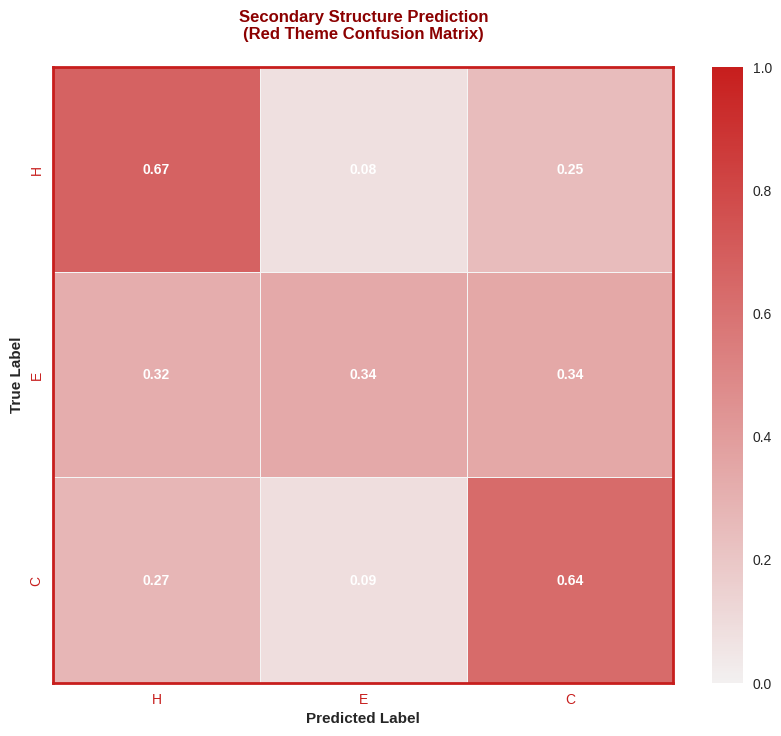

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 设置全局红色系风格
plt.style.use('seaborn')
red_palette = sns.light_palette("#C71E1D", as_cmap=True)

def plot_red_confusion_matrix(model, X_val, y_val):

    model.eval()
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for i in range(0, len(X_val), 32):
            inputs = X_val[i:i+32]
            targets = y_val[i:i+32]
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=-1)
            mask = targets != -1
            all_preds.append(preds[mask])
            all_targets.append(targets[mask])
    
    preds_flat = torch.cat(all_preds).cpu().numpy()
    targets_flat = torch.cat(all_targets).cpu().numpy()
    cm = confusion_matrix(targets_flat, preds_flat, normalize='true')
    
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        cm, 
        annot=True, 
        fmt=".2f", 
        cmap=red_palette,
        vmin=0, 
        vmax=1,
        linewidths=0.5,
        linecolor="#F5F5F5",
        xticklabels=['H', 'E', 'C'],
        yticklabels=['H', 'E', 'C'],
        annot_kws={"color": "white", "weight": "bold"}
    )
    
    # 美化样式
    ax.set_facecolor("#FFEBEE")  # 浅红色背景
    plt.title("Secondary Structure Prediction\n(Red Theme Confusion Matrix)", 
              fontweight="bold", pad=20, color="#8B0000")
    plt.xlabel("Predicted Label", fontweight="bold")
    plt.ylabel("True Label", fontweight="bold")
    plt.xticks(color="#C71E1D")
    plt.yticks(color="#C71E1D")
    
    # 添加红色边框
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color("#C71E1D")
        spine.set_linewidth(2)
    
    plt.savefig("red_confusion_matrix.png", dpi=300, bbox_inches="tight")
    plt.show()

# 调用函数
plot_red_confusion_matrix(model, X_val, y_val)

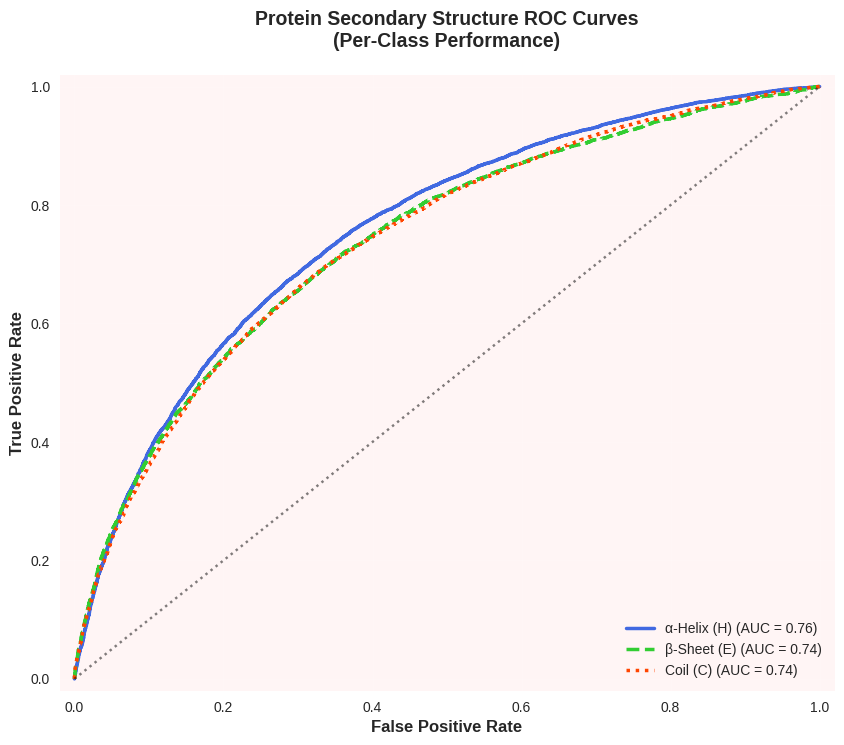

In [73]:
import torch
import numpy as np
from sklearn.preprocessing import label_binarize  # 添加此导入
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_distinct_roc_curves(model, X_val, y_val):
    """绘制高区分度的三色ROC曲线（H/E/C三类）"""
    device = next(model.parameters()).device
    model.eval()
    
    # 1. 收集预测概率和真实标签（过滤padding）
    all_probs, all_labels = [], []
    with torch.no_grad():
        for i in range(0, len(X_val), 32):
            inputs = X_val[i:i+32].to(device)
            targets = y_val[i:i+32]
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=-1)
            mask = targets != -1
            all_probs.append(probs[mask].cpu())
            all_labels.append(targets[mask].cpu())
    
    probs = torch.cat(all_probs).numpy()
    labels = torch.cat(all_labels).numpy()
    
    # 2. 多分类处理（必须导入label_binarize）
    n_classes = 3
    binarized_labels = label_binarize(labels, classes=range(n_classes))
    
    # 3. 设置高对比度颜色和样式
    colors = ['#4169E1', '#32CD32', '#FF4500']  # 皇家蓝, 酸橙绿, 橙红
    linestyles = ['-', '--', ':']  # 实线/虚线/点线
    class_names = ['α-Helix (H)', 'β-Sheet (E)', 'Coil (C)']
    
    # 4. 绘制图形
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(binarized_labels[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, 
                 color=colors[i],
                 linestyle=linestyles[i],
                 lw=2.5,
                 label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    # 5. 图形美化
    plt.plot([0, 1], [0, 1], 'k:', alpha=0.5)  # 对角线参考线
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate', fontsize=12, weight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, weight='bold')
    plt.title('Protein Secondary Structure ROC Curves\n(Per-Class Performance)', 
              fontsize=14, pad=20, weight='bold')
    plt.legend(loc="lower right", framealpha=0.9)
    plt.grid(True, alpha=0.2)
    
    # 6. 保存输出

    plt.show()

# 调用示例
plot_distinct_roc_curves(model, X_val, y_val)

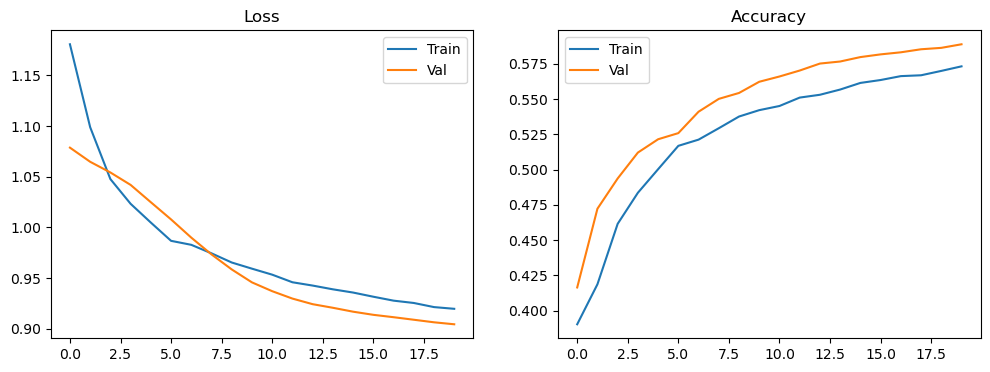

In [62]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Val')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.title('Accuracy')
plt.legend()
plt.show()

In [63]:
#导入predict函数
from ProcessData import predict,read

In [64]:
_1,_2,pdb_ids_test,pdb_files_test=read()
for pdb_id in pdb_ids_test:
    predict(model,pdb_id,pdb_ids_test,pdb_files_test)

Training PDB IDs: ['1BS4', '1CLD', '1CYY', '1D38', '1EDK', '1EZZ', '1F21', '1F2W', '1F8C', '1FBL', '1FG0', '1HJA', '1KMI', '1KYV', '1LAU', '1NAH', '1PF9', '1RCC', '1S1Z', '1SQ1', '1UAO', '1WQB', '1XXS', '1YX3', '1ZL8', '2AYO', '2BIV', '2CAI', '2CQ7', '2D82', '2DEU', '2DGT', '2E11', '2H56', '2JVN', '2M16', '2MWB', '2NNF', '2OEL', '2PL2', '2PPW', '2R5Z', '2RC5', '2RG8', '2UXV', '2VAP', '2WBP', '2XR9', '2YVV', '3ASE', '3BOF', '3DM1', '3F5F', '3FVD', '3H5L', '3HAD', '3HKI', '3I71', '3L9M', '3LFI', '3LSJ', '3LTF', '3LZS', '3MXT', '3OXI', '3QHQ', '3S9B', '3T7Z', '3U4B', '3WBY', '3WP4', '3ZZ7', '4AY7', '4HBW', '4HJT', '4HKC', '4HLI', '4KBY', '4KE3', '4KYX', '4LTB', '4P1O', '4S21', '4U5J', '4UG6', '4ZKX', '5BJ4', '5CCX', '5CYB', '5D46', '5DOQ', '5DQV', '5E2X', '5EQ7', '5EQA', '5FW1', '5GR1', '5HG9', '5INO', '5JPP', '5KAL', '5L0D', '5LFS', '5NMM', '5OQN', '5OSE', '5OWE', '5OZQ', '5SAO', '5TZZ', '5UI0', '5UN6', '5UUK', '5VIJ', '5VMR', '5WIU', '5X5J', '5Y7F', '5YA6', '5YD7', '6CL0', '6F1G', '6H3P

KeyboardInterrupt: 